In [1]:
!wget -qq https://github.com/IlyaGusev/gazeta/releases/download/2.0/gazeta_jsonl_v2.tar.gz -O gazeta.tar.gz
!tar -xvf gazeta.tar.gz
!pip install -qq pymorphy2 fasttext annoy

gazeta_train.jsonl
gazeta_val.jsonl
gazeta_test.jsonl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 106.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import warnings
warnings.filterwarnings("ignore")

import re
import json

import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords

import annoy

from pymorphy2 import MorphAnalyzer

import gensim
from gensim.models import Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec
import fasttext

import string
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve, classification_report

from typing import Union

pd.set_option("display.max_colwidth", None)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
cache = {}

def read_dataset(filename: str) -> pd.DataFrame:
    records = []
    with open(filename, "r") as infile:
        for line in infile:
            records.append(json.loads(line))
    return pd.DataFrame(records)

In [4]:
train = read_dataset("gazeta_train.jsonl")
valid = read_dataset("gazeta_val.jsonl")
test = read_dataset("gazeta_test.jsonl")

total = pd.concat([train, valid, test], axis=0)

In [67]:
total.head(1)

date                                                    url  \
0  2010-06-01 10:35:49  https://www.gazeta.ru/auto/2010/05/31_a_3377717.shtml   

                                                                                                                                                                                                                                                                                                        summary  \
0  С 2011 года правительство отменяет самый раздражающий граждан налог – транспортный. Но поборы автомобилистов не прекратятся – налоги завуалируют в бензиновые акцизы и платные дороги, а цены на товары подскочат. Зато теперь собираемые деньги обещают пустить только на строительство и содержание дорог.   

         title  \
0  Налог в бак   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

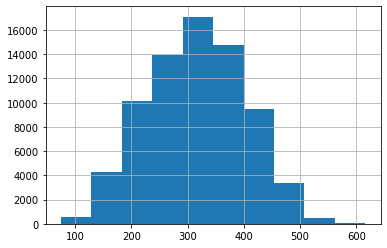

In [68]:
total["summary"].str.len().hist()

In [71]:
total["summary"].to_csv(r'train.txt', header=None, index=None, sep='\t', mode='a', encoding='utf-8')

In [5]:
pymorphy2_analyzer = MorphAnalyzer()
wp_tokenize = WordPunctTokenizer()
punctuation = string.punctuation

russian = stopwords.words("russian")
english = stopwords.words("english")

In [6]:
def preprocess(text: str, 
               remove_punct: bool = True,
               lemma: bool = True) -> list:

    if not isinstance(text, str):
        text = str(text)

    text = re.sub("\s\s+", " ", text)
    if remove_punct:
        text = re.sub(r"[^a-zA-Zа-яА-Я0-9]", " ", text)
        text = re.sub(r"[^a-zA-Zа-яА-Я]", " ", text)
        text = re.sub(r"[^\w\s]", " ", text)
    else:
        text = re.sub(f"[^a-zA-Zа-яА-Я{punctuation}]", " ", text)

    text = text.lower().strip().replace(',', '')
    text = [w for w in text.split() if len(w)>1]
    text = ' '.join([w for w in text if w not in russian and w not in english])
    
    text = wp_tokenize.tokenize(text)
    
    if lemma:
        lemm_text = []
        # text = [pymorphy2_analyzer.parse(w)[0].normal_form for w in text]
        for word in text:
            if word in cache:
                lemm_text.append(cache[word])
            else:
                temp_w = cache[word] = pymorphy2_analyzer.parse(word)[0].normal_form
                lemm_text.append(temp_w)
        return lemm_text
    
    return text

In [7]:
# train["summary_prep"] = train["summary"].apply(preprocess)
# valid["summary_prep"] = valid["summary"].apply(preprocess)
# test["summary_prep"] = test["summary"].apply(preprocess)

total["summary_prep"] = total["summary"].apply(preprocess)

In [97]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def get_topk_similar(text, vec_corpus, k=5):
    similarity = softmax(100 * text @ vec_corpus.T)
    indices = np.argsort(similarity)[::-1]
    return indices[:k].tolist()

In [ ]:
# model = fasttext.train_unsupervised('train.txt', model='skipgram')  # unsupervised as we do not have labels

In [ ]:
# print(model['правительство'])  # get embedding

In [86]:
wmodel = Word2Vec(size=200, window=5, min_count=2, sg=1, hs=0, negative=10, workers=32, seed=34)

wmodel.build_vocab(total["summary_prep"].values, progress_per=200)

wmodel.train(total["summary_prep"].values, total_examples=wmodel.corpus_count, epochs=20, report_delay=1)
wmodel.init_sims(replace=True)  # compute L2 norms istead of raw vectors / wmodel now "read-only"

In [ ]:
modelFT = FastText(sentences=total["summary_prep"].values, vector_size=200, min_count=1, window=5, negative=10, workers=32, seed=34)

In [87]:
wmodel.most_similar(positive=['женщина', 'спортсмен'], negative=['мужчина'])

[('спортсменка', 0.5283582806587219),
 ('атлет', 0.4796120226383209),
 ('биатлонистка', 0.4649542570114136),
 ('кэллахан', 0.46061283349990845),
 ('гимнастка', 0.45593640208244324),
 ('биляла', 0.45045411586761475),
 ('допинг', 0.44988030195236206),
 ('эритропоэтина', 0.4471461772918701),
 ('тяжелоатлет', 0.443185031414032),
 ('фигуристый', 0.44306042790412903)]

In [88]:
wmodel.most_similar(positive=['договор', 'мир'], negative=['конфликт'])

[('рсмд', 0.3980568051338196),
 ('европа', 0.378971129655838),
 ('версальский', 0.3737602233886719),
 ('ратифицировать', 0.37301528453826904),
 ('мировой', 0.37288761138916016),
 ('ненападение', 0.3664640784263611),
 ('снв', 0.3617566227912903),
 ('непродление', 0.3599446415901184),
 ('дрсмд', 0.3552972674369812),
 ('соглашение', 0.3541334271430969)]

In [89]:
def aggregate_vectors(items, agg_func=np.mean):
    n = len(items)
    item_vec = np.zeros((n, 200))
    for i in range(n):
        try:
            item_vec[i, :] = wmodel.wv.get_vector(items[i])
        except KeyError:
            item_vec[i, :] = np.zeros((200,))

    return agg_func(item_vec, axis=0)

In [92]:
aggregate_vectors(total["summary_prep"].iloc[0]).shape

(200,)

In [ ]:
# https://github.com/klyshinsky/NLP_VVSU_2021/blob/main/Lecture_20210511-W2V.ipynb

In [93]:
wmodel.wv.get_vector("женщина") @ wmodel.wv.get_vector("президент")  # discriminative embeddings :)

0.1591447

In [94]:
X = pd.DataFrame(data=np.zeros((len(total), 200)), columns=[f"feat_{i+1}" for i in range(200)])
for idx, row in X.iterrows():
    X.iloc[idx, :] = aggregate_vectors(total["summary_prep"].iloc[idx])

In [100]:
indices = get_topk_similar(aggregate_vectors("новости спорт европа".split()), X)

In [101]:
total["summary"].iloc[indices]

22639                Александр Третьяков стал третьим на этапе Кубка мира по скелетону в Кенигзее. Иван Скобрев пока не совсем удачно выступает на чемпионате Европы по конькобежному спорту в классическом многоборье, а российские лыжники даже не вышли в финал в спринте на этапе Кубка мира в Либереце.
15465                                                                                                 В голландском Херенвене завершился чемпионат мира по конькобежному спорту на отдельных дистанциях, по итогам которого сборная России, завоевав серебро и бронзу, стала восьмой в общекомандном зачете.
24173                                                                                                                                                                      Российские лыжники финишировали третьими в мужской эстафете на чемпионате мира по лыжным видам спорта. Золото завоевали норвежцы.
9978     Министр спорта, туризма и молодежной политики Виталий Мутко подвел итоги чемпионата мира

In [102]:
indices = get_topk_similar(aggregate_vectors("налоги транспорт новости".split()), X)

In [103]:
total["summary"].iloc[indices]

41869                                                                                                                                                                                                                                МЦК создано для распределения пассажиропотока, уменьшения времени в пути и удобства пассажиров, передвигающихся по Москве на общественном транспорте.
17973    Москвичи начинают пересаживаться из машин в общественный транспорт, рапортуют столичные власти. Прирост пассажиропотока идёт в основном за счёт рельсового транспорта, а число желающих пользоваться автобусами и троллейбусами практически не изменилось. Зато на участках, где под общественный транспорт выделили специальные полосы, сильно упали скорости остального потока.
10820                                                                                                               Столичным водителям разрешили парковаться на тротуарах. Инициатива принадлежит департаменту транспорта: по мнению чиновников, 

**Doc2Vec**

In [24]:
def read_corpus(series, tokens_only=False):
    for i, tokens in enumerate(series):
        tokens = gensim.utils.simple_preprocess(tokens)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [26]:
train_corpus = list(read_corpus(train["summary_prep"].apply(' '.join).values))

In [27]:
dmodel = Doc2Vec(vector_size=200, min_count=2, epochs=20, window=10, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=42)
dmodel.build_vocab(train_corpus)

dmodel.train(train_corpus, total_examples=dmodel.corpus_count, epochs=dmodel.epochs)

In [30]:
X = np.empty((len(test["summary_prep"]), 200))

for i, token in enumerate(test["summary_prep"]):
    X[i, :] = dmodel.infer_vector(token)

In [59]:
get_topk_similar(dmodel.infer_vector("новости мировой политики"), X)

array([3343, 1498, 4076, 1517, 3526])

In [60]:
test["summary"].iloc[[3343, 1498, 4076, 1517, 3526]]

3343         Из-за роста распространения новых штаммов коронавируса зарубежные страны вновь ограничивают авиасообщение. Так, в США, некоторых странах Европы и Израиле ограничили перелеты из-за британской и южноафриканской мутации SARS-CoV-2. Великобритания закрыла границы с более чем 10 странами из-за бразильского штамма. Во многих странах Азии запрещены авиаперевозки из всех государств с высоким уровнем заболевания, а Австралия не планирует открываться для туристов до конца 2021 года.
1498                                                                                                                          Последний использовавшийся в России для пассажирских перевозок Ту-154 выведен из эксплуатации. Свой заключительный полет он совершил из Мирного в Новосибирск. Дальнейшую судьбу машины определят позднее. Российские авиакомпании начали отказываться от Ту-154 еще в 2000-х годах по причине экономической нецелесообразности и запрета на полеты этого самолета в Европе.
4076              

In [32]:
import gensim.downloader as api

In [45]:
rus_model = api.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


In [50]:
rus_model.most_similar(positive=['женщина_NOUN', 'спортсмен_NOUN'], negative=['мужчина_NOUN'])

[('спортсменка_NOUN', 0.6279226541519165),
 ('спорт_NOUN', 0.6089626550674438),
 ('фигурист_NOUN', 0.6064136028289795),
 ('легкоатлет_NOUN', 0.5843838453292847),
 ('тренер_NOUN', 0.582610011100769),
 ('ориентировщик_NOUN', 0.5732560157775879),
 ('соревнование_NOUN', 0.5651782751083374),
 ('футболист_NOUN', 0.556661069393158),
 ('теннисист_NOUN', 0.555870771408081),
 ('атлет_NOUN', 0.5413795709609985)]

**Annoy knn centroids approximation**

In [105]:
modelFT = FastText(sentences=total["summary_prep"].values, size=200, min_count=1, window=5, negative=10, workers=32, seed=34)

In [106]:
modelWV = Word2Vec(sentences=total["summary_prep"].values, size=200, min_count=1, window=5, negative=10, workers=32, seed=34)

In [119]:
# efficient nearest neighbor search
w2v_index = annoy.AnnoyIndex(200, "angular")  # Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot"
ft_index = annoy.AnnoyIndex(200, "angular")


for i in range(len(total)):
    n_w2v = 0
    n_ft = 0
    vector_ft = np.zeros((200,))
    vector_wv = np.zeros((200,))

    for word in total["summary_prep"].iloc[i]:
        if word in modelWV.wv:
            vector_wv += modelWV.wv[word]
            n_w2v += 1
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word]
            n_ft += 1
    if n_w2v > 0:
        vector_wv = vector_wv / np.linalg.norm(vector_wv) # /= n_w2v
    if n_ft > 0:
        vector_ft = vector_ft / np.linalg.norm(vector_ft)  # /= n_ft

    w2v_index.add_item(i, vector_wv)  # adds item i (any nonnegative integer) with vector v
    ft_index.add_item(i, vector_ft)

    if i > 100_000:
        break

w2v_index.build(10)  # builds a forest of n_trees=10 trees. More trees gives higher precision when querying. After calling build, no more items can be added.
ft_index.build(10)
# https://github.com/spotify/annoy

True

In [120]:
def get_recommendation(query, index, model, df=total, topk=5):
    query = preprocess(query)
    vector = np.zeros((200, ))
    for word in query:
        vector += model.wv[word]
    vector = vector / np.linalg.norm(vector)
    response = index.get_nns_by_vector(vector, topk)  # returns the topk closest items
    return df["summary"].iloc[response]

In [121]:
get_recommendation("новости мировой политики", w2v_index, modelWV)

56243         Саммит G7, закончившийся сегодня во французском Биаррице, показал: внимание публики во всем мире в наше время привлекают не столько политические заявления, касающиеся изменения климата или тарифной войны между США и Китаем, сколько манера общения мировых лидеров. Кто и что сказал – не слишком существенно: другое дело – какими знаками внимания обмениваются лидеры стран-членов «большой семерки» и их супруги.
57451                                                                                        В Америке разгорелся политический скандал после звонка президента США Дональда Трампа украинскому коллеге Владимиру Зеленому. Политика вновь влияет и с переменным успехом давит на фондовый рынок. Например, для S&P 500 и Nasdaq вторник стал худшим днем месяца. На этом фоне миллиарды начали терять даже бизнесмены из списка Forbes.
8419                                 Во французском Довиле открывается саммит стран «большой восьмерки». Впервые одной из тем в рамках саммита окажется 

In [122]:
get_recommendation("новости мировой политики", ft_index, modelFT)

43335                                                                                                                                                                                        Компания Marvel уволила автора комиксов по «Звездным войнам» Чака Вендига за «непристойное поведение» в социальных сетях. По мнению самого Вендига, это произошло из-за его критических постов по поводу политической (и не только) ситуации в США и мире в целом.
22735                                                                                                                                         Российская экономическая политика сводится к попыткам устоять в случае катаклизмов ведущих экономик мира под прекраснодушные разговоры о бурном росте ВВП и продолжении модернизации. При таком раскладе Россия не войдет в число экономических оплотов мира и не реализует свои гигантские политические амбиции.
3378     Владимир Путин предупредил мировое сообщество об угрозе начала борьбы всех против всех на фоне 